<a href="https://colab.research.google.com/github/DanieleFoscarin/NNDL_hw1/blob/main/NNDL_hw1_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of handwritten digits (MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (hand-written digit) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix

from tqdm import tqdm, tqdm_notebook, notebook

from itertools import product

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
torch.manual_seed(0)

Training device: cuda


Download the dataset and tronsform it to Tensors

In [ ]:
to_tensor = torchvision.transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True, transform=to_tensor)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True, transform=to_tensor)

train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

How to get an image and the corresponding label:

In [ ]:
print(train_dataset[0].shape())

AttributeError: ignored

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [ ]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [ ]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


## NET models

In [ ]:

class CnnNet(nn.Module):
    def __init__(self, net_params):

        super().__init__()

        self.net_params = net_params

        #better to fix the kernel size?
        conv1_ch = int(net_params[0])
        conv1_ker = 3
        conv2_ch = int(net_params[1])
        conv2_ker = 3
        fc1_n = int(net_params[2])
        drop_rate = net_params[3]

        # o = [i + 2*p - k - (k-1)*(d-1)]/s + 1

        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(drop_rate)
        self.maxpool = nn.MaxPool2d(2,2)
        self.conv1 = nn.Conv2d(1, conv1_ch, conv1_ker, padding=1)
        self.conv2 = nn.Conv2d(conv1_ch, conv2_ch, conv2_ker, padding=1)
        self.fc1 = nn.Linear(conv2_ch * 14 * 14, fc1_n)
        self.fc2 = nn.Linear(fc1_n, 10)


    def forward(self, x, additional_out=False):

        x = self.maxpool(self.dropout(self.relu(self.conv1(x))))
        x = self.dropout(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.logsoftmax(self.fc2(x))


        return x


In [ ]:
class FcNet(nn.Module):
    
    def __init__(self, net_params):

        super().__init__()

        Ni, Nh1, Nh2, Nh3, No = net_params[0], net_params[1], net_params[2], net_params[3], net_params[4]


        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
        self.out = nn.Linear(in_features=Nh3, out_features=No)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop_rate)
        self.softmax = nn.Softmax()
        
    def forward(self, x, additional_out=False):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.out(x)
        return x

Training routine

## Training loop function

In [ ]:

def training_loop(net, optimizer, loss_fn, 
                  train_dataloader, val_dataloader, n_epochs, verbose=False):
    train_loss_log = []
    val_loss_log = []
    val_acc_log = []
    train_acc_log = []
    for epoch_num in notebook.tqdm(range(n_epochs)):
        if verbose:
            print(f'EPOCH {epoch_num}')

        #training step
        train_loss = []
        train_acc = []
        net.train()
        for sample_batched in train_dataloader:
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            # label_batch = torch.nn.functional.one_hot(label_batch)

            #forward
            out = net(x_batch)
            #compute loss
            loss = loss_fn(out, label_batch)

            #backpropagation
            net.zero_grad()
            loss.backward()

            #update weights
            optimizer.step()

            #save train loss
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

            #compute accuracy in the batch
            _, predicted = torch.max(out, 1)
            correct = (predicted == label_batch).sum().item()
            acc_batch = correct/label_batch.size(0)
            train_acc.append(acc_batch)


        #save average train loss and accuracy
        train_loss = np.mean(train_loss)
        train_acc = np.mean(train_acc)
        if verbose:
            print(f"train loss: {train_loss}")
            print(f"train accuracy: {train_acc}")
        train_loss_log.append(train_loss)   
        train_acc_log.append(train_acc) 

        #validation
        val_loss= []
        val_acc = []
        correct = 0
        net.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in val_dataloader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                # Forward pass
                out = net(x_batch)

                # Compute loss
                loss = loss_fn(out, label_batch)

                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

                #compute accuracy in the batch
                _, predicted = torch.max(out, 1)
                correct = (predicted == label_batch).sum().item()
                acc_batch = correct/label_batch.size(0)
                val_acc.append(acc_batch)
                

            # Save average validation  and accuracy
            val_acc = np.mean(val_acc)
            val_loss = np.mean(val_loss)
            if verbose:
                print(f"validation loss: {val_loss}")
                print(f"validation accuracy: {val_acc}")
            val_loss_log.append(val_loss)
            val_acc_log.append(val_acc)  

    return train_loss_log, val_loss_log, train_acc_log, val_acc_log
    #fix return in main grid search
    #add train_acc_log

# Grid search training

Choice of learning rate range is based on this article https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2

In [ ]:
batch_gs = np.array([64, 128, 256])
l2_gs = np.array([0,4e-3])
lr_gs = np.array([0.0005, 0.001,0.005])
conv1_ch_gs = np.array([8,16,32])
conv2_ch_gs = np.array([8,16,32])
fc1_gs = np.array([50,100])
drop_gs = np.array([0.1,0.2,0.3])

#maybe increase depending on how long it takes
max_size = 100

grid = product(batch_gs, l2_gs, lr_gs, conv1_ch_gs, conv2_ch_gs, fc1_gs, drop_gs)

grid_df = pd.DataFrame(list(grid))
print(len(grid_df))

if len(grid_df)>max_size:
    chosen = np.random.choice(len(grid_df), max_size, replace=False)
    chosen = np.sort(chosen)
    grid_df = grid_df.iloc[chosen,:]
    
grid_df

972


,0,1,2,3,4,5,6
7,64,0.000,0.0005,8,16,50,0.2
12,64,0.000,0.0005,8,32,50,0.1
20,64,0.000,0.0005,16,8,50,0.3
40,64,0.000,0.0005,32,8,100,0.2
41,64,0.000,0.0005,32,8,100,0.3
...,...,...,...,...,...,...,...
937,256,0.004,0.0050,16,8,50,0.2
939,256,0.004,0.0050,16,8,100,0.1
949,256,0.004,0.0050,16,32,50,0.2
958,256,0.004,0.0050,32,8,100,0.2


In [ ]:
csv_name = "grid_MNIST_100ep_avg02.csv"
path_out = "/content/drive/My Drive/NNDL_hw1_models/"

In [ ]:
n_epochs = 30



val_search = []
#big grid search loop
for i in notebook.tqdm(range(len(grid_df))):
    # params= {'n_epochs': n_epochs, 'batch_size': grid_df.iloc[i,0], 'l2': grid_df.iloc[i,1], 'lr': grid_df.iloc[i,2] 'net_params': list(grid_df.iloc[i,3:7]) }
    # print(params)
    batch_size = grid_df.iloc[i,0]
    l2 = grid_df.iloc[i,1]
    lr = grid_df.iloc[i,2]
    net_params = list(grid_df.iloc[i,3:7])
 
    
    train_dataloader = DataLoader(train_set, batch_size=int(batch_size), shuffle=True, num_workers=0)
    val_dataloader  = DataLoader(val_set,  batch_size=len(val_set), shuffle=False, num_workers=0)

    # Initialize model
    ######fix
    # print(net_params)
    print(net_params)
    # net = CnnNet(net_params)
    net = CnnNet(net_params)
    net.to(device)  

    #unsure why this loss
    loss_fn = nn.NLLLoss()

    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=l2)

    train_loss_log, val_loss_log, _, _ = training_loop(net, 
                                                 optimizer=optimizer, 
                                                 loss_fn=loss_fn, 
                                                 train_dataloader=train_dataloader, 
                                                 val_dataloader=val_dataloader, 
                                                 n_epochs=n_epochs)


    val_search.append(np.mean(val_loss_log[-1*int(np.ceil(n_epochs/10))]))


    if i%5==0:
        grid_result = grid_df.iloc[:len(val_search),:]
        grid_result['val_search'] = val_search
        grid_result.to_csv(path_out+csv_name)

grid_result = grid_df.copy()
grid_result['val_search'] = val_search





grid_result.to_csv(path_out+csv_name)

[8.0, 16.0, 50.0, 0.2]



[8.0, 32.0, 50.0, 0.1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[16.0, 8.0, 50.0, 0.3]



[32.0, 8.0, 100.0, 0.2]



[32.0, 8.0, 100.0, 0.3]



[32.0, 32.0, 100.0, 0.2]



[16.0, 32.0, 100.0, 0.2]



[16.0, 32.0, 100.0, 0.3]



[8.0, 8.0, 100.0, 0.2]



[32.0, 8.0, 100.0, 0.1]



[32.0, 32.0, 100.0, 0.1]



[8.0, 32.0, 50.0, 0.1]



[16.0, 8.0, 50.0, 0.3]



[16.0, 16.0, 50.0, 0.1]



[16.0, 16.0, 50.0, 0.2]



[16.0, 16.0, 100.0, 0.1]



[16.0, 32.0, 50.0, 0.1]



[32.0, 32.0, 50.0, 0.1]



[32.0, 32.0, 100.0, 0.1]



[8.0, 8.0, 100.0, 0.2]



[8.0, 8.0, 100.0, 0.3]



[8.0, 16.0, 50.0, 0.1]



[8.0, 32.0, 100.0, 0.2]



[16.0, 8.0, 50.0, 0.2]



[8.0, 16.0, 50.0, 0.2]



[16.0, 8.0, 50.0, 0.3]



[16.0, 16.0, 50.0, 0.3]



[16.0, 32.0, 50.0, 0.1]



[32.0, 16.0, 50.0, 0.2]



[32.0, 16.0, 100.0, 0.2]



[32.0, 32.0, 100.0, 0.3]



[8.0, 8.0, 100.0, 0.2]



[8.0, 8.0, 100.0, 0.3]



[8.0, 32.0, 100.0, 0.1]



[16.0, 8.0, 50.0, 0.2]



[16.0, 8.0, 100.0, 0.1]



[16.0, 16.0, 50.0, 0.1]



[32.0, 8.0, 100.0, 0.1]



[8.0, 16.0, 50.0, 0.2]



[16.0, 16.0, 100.0, 0.2]



[16.0, 32.0, 100.0, 0.2]



[32.0, 32.0, 100.0, 0.1]



[16.0, 8.0, 50.0, 0.3]



[16.0, 16.0, 50.0, 0.1]



[16.0, 16.0, 50.0, 0.2]



[32.0, 32.0, 100.0, 0.2]



[16.0, 8.0, 100.0, 0.1]



[16.0, 16.0, 100.0, 0.1]



[32.0, 16.0, 50.0, 0.3]



[8.0, 8.0, 100.0, 0.2]



[16.0, 8.0, 50.0, 0.3]



[16.0, 16.0, 50.0, 0.2]



[16.0, 16.0, 50.0, 0.3]



[32.0, 8.0, 100.0, 0.2]



[32.0, 16.0, 50.0, 0.1]



[32.0, 16.0, 50.0, 0.3]



[16.0, 16.0, 50.0, 0.3]



[16.0, 16.0, 100.0, 0.1]



[16.0, 16.0, 100.0, 0.3]



[16.0, 32.0, 100.0, 0.3]



[32.0, 8.0, 100.0, 0.3]



[8.0, 8.0, 50.0, 0.3]



[8.0, 8.0, 100.0, 0.3]



[8.0, 16.0, 100.0, 0.3]



[16.0, 8.0, 50.0, 0.2]



[16.0, 16.0, 50.0, 0.3]



[16.0, 16.0, 100.0, 0.2]



[16.0, 32.0, 50.0, 0.1]



[8.0, 32.0, 50.0, 0.2]



[8.0, 32.0, 100.0, 0.3]



[16.0, 8.0, 100.0, 0.1]



[32.0, 8.0, 50.0, 0.2]



[32.0, 16.0, 50.0, 0.2]



[32.0, 16.0, 50.0, 0.3]



[32.0, 32.0, 100.0, 0.1]



[8.0, 8.0, 50.0, 0.2]



[8.0, 8.0, 100.0, 0.1]



[16.0, 16.0, 100.0, 0.2]



[16.0, 32.0, 50.0, 0.3]



[32.0, 8.0, 100.0, 0.1]



[32.0, 16.0, 50.0, 0.1]



[8.0, 8.0, 100.0, 0.2]



[8.0, 32.0, 100.0, 0.2]



[16.0, 8.0, 100.0, 0.2]



[16.0, 16.0, 50.0, 0.1]



[16.0, 16.0, 100.0, 0.1]



[16.0, 32.0, 100.0, 0.3]



[32.0, 32.0, 50.0, 0.2]



[8.0, 32.0, 100.0, 0.1]



[16.0, 8.0, 100.0, 0.3]



[16.0, 32.0, 100.0, 0.2]



[32.0, 8.0, 100.0, 0.1]



[32.0, 16.0, 100.0, 0.3]



[32.0, 32.0, 100.0, 0.3]



[8.0, 8.0, 50.0, 0.3]



[16.0, 8.0, 50.0, 0.2]



[16.0, 8.0, 100.0, 0.1]



[16.0, 32.0, 50.0, 0.2]



[32.0, 8.0, 100.0, 0.2]



[32.0, 16.0, 100.0, 0.1]


# Anlaysis of the grid search results

In [ ]:
grid_result = pd.read_csv(path_out+csv_name, usecols=[str(x) for x in range(7)]+[ 'val_search'])

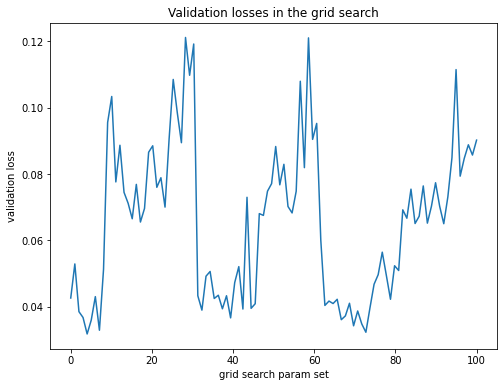

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

# ax.grid_result['val_kfold_avg'].plot()
ax.plot(np.linspace(0,len(grid_result), len(grid_result)), grid_result['val_search'])
ax.set_title('Validation losses in the grid search')
ax.set_xlabel('grid search param set')
ax.set_ylabel('validation loss')
fig.show()


In [ ]:
#sort to have the better performance at first
grid_result = grid_result.sort_values(by='val_search', )
grid_result

,0,1,2,3,4,5,6,val_search
4,64,0.000,0.0005,32,8,100,0.3,0.031778
72,256,0.000,0.0010,32,16,50,0.2,0.032298
7,64,0.000,0.0010,16,32,100,0.3,0.032906
69,256,0.000,0.0010,8,32,100,0.3,0.034245
71,256,0.000,0.0010,32,8,50,0.2,0.034791
...,...,...,...,...,...,...,...,...
29,64,0.004,0.0050,32,16,100,0.2,0.109782
94,256,0.004,0.0050,8,8,50,0.3,0.111496
30,64,0.004,0.0050,32,32,100,0.3,0.119210
58,128,0.004,0.0050,16,16,100,0.3,0.121058


In [ ]:
best_params = list(grid_result.iloc[0,:-1]) #check for this indexes
best_params

[64.0, 0.0, 0.0005, 32.0, 8.0, 100.0, 0.3]

## Retrain the best parameters model

In [ ]:
batch_size = best_params[0]
l2 = best_params[1]
lr = best_params[2]
net_params = list(best_params[3:7])
n_epochs = 50

full_train_dataloader = DataLoader(train_dataset, batch_size=int(batch_size), shuffle=True, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

# Initialize model
######fix
# print(net_params)
print(net_params)
# net = CnnNet(net_params)
net = CnnNet(net_params)
net.to(device)  

#unsure why this loss
loss_fn = nn.NLLLoss()

optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=l2)

train_loss_log, test_loss_log, train_acc, test_acc = training_loop(net, 
                                                optimizer=optimizer, 
                                                loss_fn=loss_fn, 
                                                train_dataloader=full_train_dataloader, 
                                                val_dataloader=test_dataloader, 
                                                n_epochs=n_epochs,
                                                verbose=True)

[32.0, 8.0, 100.0, 0.3]


EPOCH 0
train loss: 0.3836255967617035
train accuracy: 0.8821128731343284
validation loss: 0.13907195627689362
validation accuracy: 0.9616
EPOCH 1
train loss: 0.15676212310791016
train accuracy: 0.9522587953091685
validation loss: 0.08693014830350876
validation accuracy: 0.977
EPOCH 2
train loss: 0.1188175156712532
train accuracy: 0.9635694296375267
validation loss: 0.07106539607048035
validation accuracy: 0.9804
EPOCH 3
train loss: 0.09880382567644119
train accuracy: 0.9695329157782516
validation loss: 0.05868860334157944
validation accuracy: 0.9835
EPOCH 4
train loss: 0.08599261194467545
train accuracy: 0.9740804904051172
validation loss: 0.054661963135004044
validation accuracy: 0.9837
EPOCH 5
train loss: 0.07844026386737823
train accuracy: 0.9758628731343284
validation loss: 0.048668865114450455
validation accuracy: 0.9861
EPOCH 6
train loss: 0.07049362361431122
train accuracy: 0.9784281716417911
validation loss: 0.042448222637176514
validation accuracy: 0.9876
EPOCH 7
train loss: 

Visualize the Accuracy and Loss plots with the training set

Final training accuracy: 0.9933535447761194


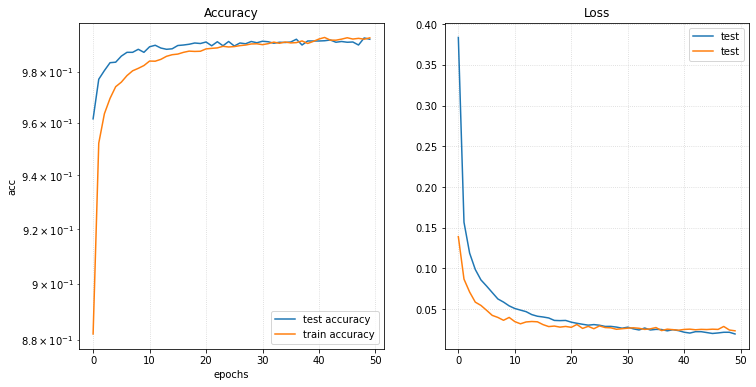

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
ax1.set_title("Accuracy")
ax2.set_title("Loss")
# ax.semilogy(train_loss_log, label="training")
ax1.plot(test_acc, label="test accuracy")
ax1.plot(train_acc, label='train accuracy')
ax2.plot(train_loss_log, label='test')
ax2.plot(test_loss_log, label='test')
ax1.grid(color='lightgrey' , linestyle=':')
ax2.grid(color='lightgrey' , linestyle=':')

ax1.set_ylabel("acc")
ax1.set_xlabel("epochs")

ax1.legend()
ax2.legend()

fig.show()

print(f'Final training accuracy: {train_acc[-1]}')

## save and load best network

Skip the final training loading the model

In [ ]:
path_out = "/content/drive/My Drive/NNDL_hw1_models/"
model_name = "best_cnn01"

In [ ]:


### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = net.state_dict()
# Save the state dict to a file
torch.save(net_state_dict, path_out+model_name)

In [ ]:
### Reload the network state
# First initialize the network (if not already done)
net = Net(net_params) 
# Load the state dict previously saved
net_state_dict = torch.load('net_parameters.torch')
# Update the network parameters
net.load_state_dict(net_state_dict)

## prediction for the classes on the test set 

Inference on the test set

In [ ]:
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)


all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
  for sample_batched in test_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)
    # Forward pass
    out = net(x_batch)
    # Save outputs and labels
    all_inputs.append(x_batch)
    all_outputs.append(out)
    all_labels.append(label_batch)
# Concatenate all the outputs and labels ina single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

# test_loss = loss_fn(all_outputs, all_labels)
# print(f"AVERAGE TEST LOSS: {test_loss}")




[7 2 1 ... 4 5 6]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Get predicted classes

In [ ]:
predicted_label = torch.argmax(all_outputs, 1)
predicted_label = predicted_label.cpu().numpy()
test_label = all_labels.cpu().numpy()



# Visualization of results and features

cofusion matrix

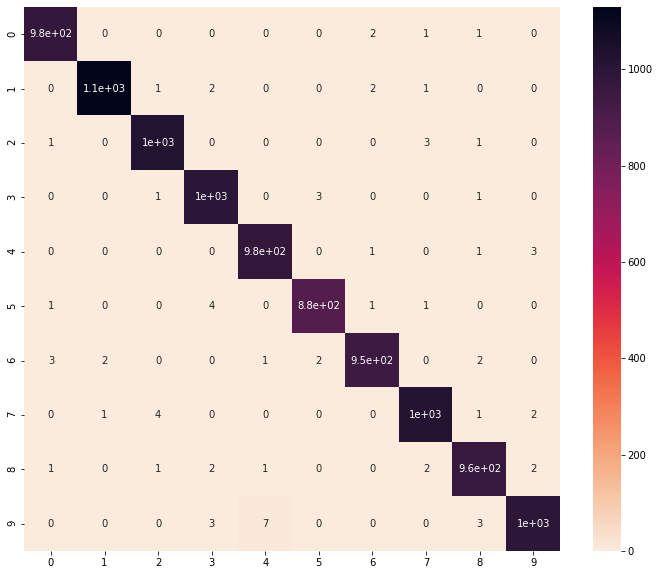

In [ ]:
cm_array = confusion_matrix(test_label, predicted_label, normalize=None)
# print(cm_array)
cm = pd.DataFrame(cm_array,index=range(10), columns=range(10))

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, cmap="rocket_r")

plt.show()

Fron the confusion matrix we can see there are very few wrongly classified samples

In [ ]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

RuntimeError: ignored